# SAT

Importing Code to represent rectangles and plot groups of rectangles

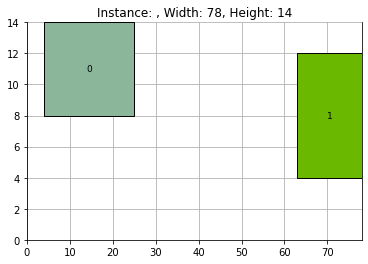

In [1]:
import sys
sys.path.append('../')
from utils.utils import *

plot_rectangles([Rectangle(21,6,4,8), Rectangle(15,8,63,4)])

### VLSI Instance Parser



######
C:\Users\aleda\Documents\GitHub\VLSI\sat
Testing the parse and the bounds computations for instance 1
height:  

3 width:  3
height:  5 width:  3
height:  3 width:  5
height:  5 width:  5
Tape width:  8
LB:  8


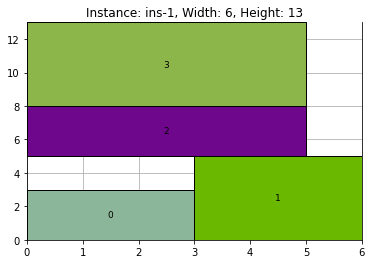

UB:  13
UB_rotation:  13
######


In [2]:
!pip install z3-solver
from z3 import *
import re

class VLSI_Instance():
    '''
    In this implementation, VLSI_Instance is the class representing the parsed instance to be solved (with a
    fixed width of the container and with a defined amount of rectangles to be placed inside that one)

    path: the path from which the instances are taken

    '''
  
    def __init__(self, path):

      rectangles = []

      with open(path, 'r') as file:
        file = file.readlines()

        for i in range(2, int(file[1]) + 2):
          width, height = file[i].split()
          rectangles.append(Rectangle(int(width), int(height)))

      self.name = path
      self.W = int(file[0])
      self.H = None
      self.n_instances = int(file[1])
      self.rectangles = rectangles

      for i in range(0, len(self.rectangles)):
        if self.rectangles[i].width > self.W:
          raise Exception(f"The width of the rectangle n.{i} is over the container width W = {self.W}")



    def load_instance(self, H, rotate=False):
      self.H = H
      self.enc_x = [[Bool(f"encx_({i},{j})") for j in range(self.W)] for i in range(self.n_instances)]
      self.enc_y = [[Bool(f"ency_({i},{j})") for j in range(self.H)] for i in range(self.n_instances)]
      self.lr = [[Bool(f"lr_({i},{j})") for j in range(self.n_instances)] for i in range(self.n_instances)]
      self.ud = [[Bool(f"ud_({i},{j})") for j in range(self.n_instances)] for i in range(self.n_instances)]
      self.s = Solver()
      if rotate:
        self.r = [Bool(f"r_({i})") for i in range(self.n_instances)]
        max_len = max(self.W, self.H)
        self.enc_x = [[Bool(f"encx_({i},{j})") for j in range(max_len)] for i in range(self.n_instances)]
        self.enc_y = [[Bool(f"ency_({i},{j})") for j in range(max_len)] for i in range(self.n_instances)]

    def H_LB(self):
      '''
      In this implementation, the lower bound is computed using as best case the one in which no
      blank spaces are left

      '''

      sum = 0

      for rectangle in self.rectangles:
          sum = sum + (rectangle.height*rectangle.width)
      return int(np.ceil(sum/self.W))


    def H_UB(self, plot=False):
      '''
      In this implementation, the upper bound is computed building a first
      relaxed version of the problem: the rectangles are placed one to the right
      of another in a line starting from the bottom left corner and when the next
      rectangle is wider than the available width on the actual line, it is placed
      on a new row, over the row of the previously placed rectangles.
      H_UB is computed quickly and provides a bound which is way better than H_UB_naive.
      (this advantage is more evident with instances having many rectangles).

      '''

      W = self.W
      placer_x = 0
      occupied_height= [0]*W


      for r in self.rectangles:

        occupied_height_copy = occupied_height.copy()
        placer_x = np.argmin(occupied_height_copy)
        placer_y = min(occupied_height_copy)

        while ((placer_x + r.width)>W or any([x > placer_y for x in occupied_height[placer_x:(placer_x + r.width)]])):
          occupied_height_copy.remove(placer_y)
          placer_x = np.argmin(occupied_height_copy)
          placer_y = min(occupied_height_copy)

        #lowest_height = max(occupied_height[placer_x:(placer_x + r.width)])

        r.x = placer_x
        r.y = placer_y

        for i in range(placer_x, placer_x + r.width):
          occupied_height[i] = placer_y + r.height

        placer_x += r.width



      if plot:
        plot_rectangles(self.rectangles, title = self.name)

      return max([(r.height + r.y) for r in self.rectangles])


    def H_UB_naive(self):

      sum = 0

      for rectangle in self.rectangles:
          sum = sum + rectangle.height
      return sum

    def H_UB_rotation(self):

      sum = 0

      for rectangle in self.rectangles:
          sum = sum + min(rectangle.height, rectangle.width)
      return min(sum, self.H_UB())

    def biggest_rectangle_index(self):

      biggest_rectangle_index = 0
      area = 0
      for i in range(len(self.rectangles)):
        a = self.rectangles[i].width * self.rectangles[i].height
        if (a > area):
          area = a
          biggest_rectangle_index = i

      return biggest_rectangle_index



# test 
print("######")
print(os.getcwd())
print("Testing the parse and the bounds computations for instance 1")
instance = VLSI_Instance('../instances/ins-1.txt')
instance.load_instance(50)

for r in instance.rectangles:
  print("height: ", r.height, "width: ", r.width)

print("Tape width: ", instance.W)
print("LB: ", instance.H_LB())
print("UB: ", instance.H_UB(plot=True))
print("UB_rotation: ", instance.H_UB_rotation())
print("######")

## Domain and search strategy

In SAT it is not possible to specify a function to minimize as instead we've done in CP. In this case it is necessary to define a *lower bound* and an *upper bound* to explore the domain. The width of the strip *W* is predefined (and therefore fixed) while *H* can be chosen as follows:

$$H_{LB} = \lceil \frac{\sum_{i \in \{0, .., N-1\}}{A_{i}}}{W} \rceil =\lceil \frac{\sum_{i \in \{0, .., N-1\}}{width_{i} \cdot height_{i}}}{W} \rceil$$

$$H_{{UB}_{naive}} = \sum_{i \in \{0, .., N-1\}} height_i$$

$$H_{{UB}_{naive-rotation}} = \sum_{i \in \{0, .., N-1\}}{min({width_i, height_i})}$$

$$H_{{UB}_{rotation}} = min(H_{{UB}_{naive-rotation}}, H_{UB})$$

Where $N$ is the number of rectangles in the current instance, $A_i$ the area of the i-th rectangle, $H_{LB}$ and $H_{UB}$ are respectively the lower bound and the upper bound for the strip height. 

$H_{LB}$ represents the best case possible, in which all the rectangles compact to a big rectangle having no empty spaces.

$H_{{UB}_{naive}}$ represent the worst posssible case, in which all the rectangles are placed one over the other.

$H_{{UB}_{naive-rotation}}$ is equivalent to $H_{{UB}_{naive}}$ but takes in consideration a possible rotation of each rectangle (on the shortest side).

$H_{UB}$ is computed solving a relaxed version of the problem: the rectangles are placed one to the right of another in a line starting from the bottom left corner and when the next rectangle is wider than the available width on the actual line, it is placed on a new line over the height of the highest rectangle in the actual line. $H_{UB}$ is computed fastly and provides a bound which is way better than $H_{{UB}_{naive}}$(this advantage is more evident with instances having many rectangles).

$H_{{UB}_{rotation}}$ is the upper bound for the height in case the rotations are taken into consideration.


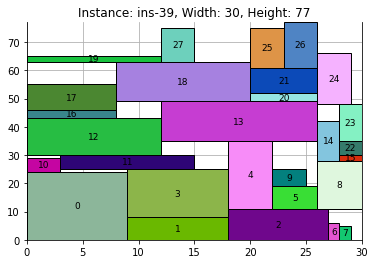

Height UB:  77


In [3]:
instance = VLSI_Instance("../instances/ins-39.txt")

print("Height UB: ", instance.H_UB(plot=True))

## Encoding

We've chosen the order encoding to represent natural numbers: in this way we have a direct and easy way to convert numbers from the original to the SAT representation (and viceversa), also simplifying the comparison between numbers.

An example of order encoding for 4 bit numbers

$$0 \rightarrow 1 1 1 1 \rightarrow enc_0 = TTTT$$
$$1 \rightarrow 0 1 1 1 \rightarrow enc_1 = FTTT$$
$$2 \rightarrow 0 0 1 1 \rightarrow enc_2 = FFTT$$
$$3 \rightarrow 0 0 0 1 \rightarrow enc_3 =  FFFT$$
$$4 \rightarrow 0 0 0 0 \rightarrow enc_4 = FFFF$$

Using this encoding it is easy to see that the encoding of a natural number $n \in [0, n_{max}]$ is $$[ \space \underbrace{F..F}_\text{n} \space \underbrace{T..T}_\text{$n_{max}$-n}]$$ 

Using the 0-based indexing for the elements of the encoding $enc_a$ of a natural number $a$, we have that 
$$enc_{a,i} \rightarrow enc_{a,i+1}, \qquad i \in \{0,n_{max}-2\}$$

rewritten as a pure CNF clause:
$$\neg enc_{a,i} \vee enc_{a,i+1}, \qquad i \in \{0,n_{max}-2\}$$

It is also worth noticing that 
$$enc_{a,j} \Leftrightarrow a \leq j, \qquad j \in \{ 0,n_{max}-1\}$$

In [4]:
def ordinalencoder(number, max_number):
    if number > max_number:
        raise Exception("The number to encode is bigger than the maximum defined")
        
    encoded = []
    
    for i in range(0, number):
        encoded.append(False)
        
    for i in range(number, max_number):
        encoded.append(True)
        
    return encoded

def ordinaldecoder(encoded):
    i=0
    
    while (i<=(len(encoded)-1) and not(encoded[i])):
        i=i+1
        
    return i

# test
print("0 --> ",ordinaldecoder(ordinalencoder(0,4)))
print("1 --> ",ordinaldecoder(ordinalencoder(1,4)))
print("2 --> ",ordinaldecoder(ordinalencoder(2,4)))
print("3 --> ",ordinaldecoder(ordinalencoder(3,4)))
print("4 --> ",ordinaldecoder(ordinalencoder(4,4)))

0 -->  0
1 -->  1
2 -->  2
3 -->  3
4 -->  4


For each rectangle $r_{i}$, the length of the encoding of the $x$ coordinate of the i-th rectangle is 

$$ | enc_{x_{i}} | = W $$

And the length of the encoding of the $y$ coordinate of the i-th rectangle is

$$ | enc_{y_{i}} | = H $$

And to the describe the relative position of the rectangles in the strip we add two kinds of variables: 

*   the left-right $lr_{i,j}$ which is true if $r_i$ is at the left of $r_j$ (and therefore $r_j$ is at the right of $r_i$)

*   the up-down $ud_{i,j}$ which is true if $r_i$ is above $r_j$ (and therefore $r_j$ is below $r_i$)

In [5]:
from pyparsing.core import StringStart
from z3 import *
import time
import re


class VLSI_SAT_solver:
    def domain_constraints(self, instance, break_symmetries=False):

        instances_to_constraint = list(range(instance.n_instances))

        if(break_symmetries):

            biggest_rect_index = instance.biggest_rectangle_index()
            instances_to_constraint.remove(biggest_rect_index)

            for j in range(((instance.H - instance.rectangles[biggest_rect_index].height)//2), instance.H):
                  instance.s.add(instance.enc_y[biggest_rect_index][j])
            for k in range(((instance.W - instance.rectangles[biggest_rect_index].width)//2), instance.W):
                  instance.s.add(instance.enc_x[biggest_rect_index][k])

        for i in instances_to_constraint:
            for j in range(instance.H - instance.rectangles[i].height, instance.H):
                instance.s.add(instance.enc_y[i][j])
            for k in range(instance.W - instance.rectangles[i].width, instance.W):
                instance.s.add(instance.enc_x[i][k])


    def domain_constraints_rotation(self, instance, break_symmetries=False):

        instances_to_constraint = list(range(instance.n_instances))
        r = instance.r

        for i in instances_to_constraint:

            SB_square_i = break_symmetries and (instance.rectangles[i].width == instance.rectangles[i].height)
            non_rotable = (instance.rectangles[i].height > instance.W)

            if(SB_square_i or non_rotable):
                
                for j in range(instance.H - instance.rectangles[i].height, instance.H):
                    instance.s.add(instance.enc_y[i][j])
                for k in range(instance.W - instance.rectangles[i].width, instance.W):
                    instance.s.add(instance.enc_x[i][k])

            else:
                
                for j in range(instance.H - instance.rectangles[i].height, instance.H):
                    instance.s.add(Implies(Not(r[i]),instance.enc_y[i][j]))
                for k in range(instance.W - instance.rectangles[i].width, instance.W):
                    instance.s.add(Implies(Not(r[i]), instance.enc_x[i][k]))
                for j in range(instance.H - instance.rectangles[i].width, instance.H):
                    instance.s.add(Implies(r[i],instance.enc_y[i][j]))
                for k in range(instance.W - instance.rectangles[i].height, instance.W):
                    instance.s.add(Implies(r[i], instance.enc_x[i][k]))


    def order_constraints(self, instance):

        for i in range(instance.n_instances):
            
            for j in range(len(instance.enc_x[i]) - 1):
                instance.s.add(Implies(instance.enc_x[i][j], instance.enc_x[i][j + 1]))
                
            for k in range(len(instance.enc_y[i]) - 1):
                instance.s.add(Implies(instance.enc_y[i][k], instance.enc_y[i][k + 1]))

    def no_overlap_constraints_rotation(self, instance, break_symmetries=False):
        lr = instance.lr
        ud = instance.ud
        enc_x = instance.enc_x
        enc_y = instance.enc_y
        s = instance.s
        rectangles = instance.rectangles
        H = instance.H
        W = instance.W

        for j in range(instance.n_instances):      
            for i in range(j):

                SB_square_i = False
                SB_square_j = False

                if (break_symmetries and (rectangles[i].width == rectangles[i].height)):
                    SB_square_i = True

                if (break_symmetries and (rectangles[j].width == rectangles[j].height)):
                    SB_square_j = True


                relative_positions = []

                relative_positions.append(lr[i][j])

                relative_positions.append(lr[j][i])

                relative_positions.append(ud[i][j])

                relative_positions.append(ud[j][i])

                s.add(Or(relative_positions))

                r = instance.r

                #1
                if(SB_square_i or (rectangles[i].height>W)):
                    s.add(  [ Or(Not(lr[i][j]),  Not(enc_x[j][t]))  for t in range(0, rectangles[i].width) ] )
                    s.add(  [ Or(Not(lr[i][j]), Not(enc_x[j][rectangles[i].width + s]),enc_x[i][s]) for s in range(0, W - rectangles[i].width) ] )

                else:

                    s.add(  [ Implies(Not(r[i]) , (Or(Not(lr[i][j]),  Not(enc_x[j][t]))))  for t in range(0, rectangles[i].width) ] )
                    s.add(  [ Implies(Not(r[i]) ,(Or(Not(lr[i][j]), Not(enc_x[j][rectangles[i].width + s]),enc_x[i][s]))) for s in range(0, W - rectangles[i].width) ] )

                    s.add(  [ Implies(r[i] , (Or(Not(lr[i][j]),  Not(enc_x[j][t]))))  for t in range(0, rectangles[i].height) ] )
                    s.add(  [ Implies(r[i] , (Or(Not(lr[i][j]), Not(enc_x[j][rectangles[i].height + s]),enc_x[i][s]))) for s in range(0, W - rectangles[i].height) ] )

                #2
                if(SB_square_j or (rectangles[j].height>W)):
                    s.add( [ Or(Not(lr[j][i]), Not(enc_x[i][t])) for t in range(0, rectangles[j].width) ] )
                    s.add( [ Or(Not(lr[j][i]), Not(enc_x[i][rectangles[j].width + s]), enc_x[j][s]) for s in range(0, W - rectangles[j].width) ] )

                else:

                    s.add( [ Implies(Not(r[j]), (Or(Not(lr[j][i]), Not(enc_x[i][t])))) for t in range(0, rectangles[j].width) ] )
                    s.add( [ Implies(Not(r[j]), (Or(Not(lr[j][i]), Not(enc_x[i][rectangles[j].width + s]), enc_x[j][s]))) for s in range(0, W - rectangles[j].width) ] )

                    s.add( [ Implies(r[j], (Or(Not(lr[j][i]), Not(enc_x[i][t])))) for t in range(0, rectangles[j].height) ] )
                    s.add( [ Implies(r[j], (Or(Not(lr[j][i]), Not(enc_x[i][rectangles[j].height + s]), enc_x[j][s]))) for s in range(0, W - rectangles[j].height) ] )

                #3

                if(SB_square_i or (rectangles[i].height>W)):
                    s.add( [ Or(Not(ud[i][j]), Not(enc_y[j][t])) for t in range(0, rectangles[i].height) ] )
                    s.add( [ Or(Not(ud[i][j]), Not(enc_y[j][rectangles[i].height + s]), enc_y[i][s]) for s in range(0, H - rectangles[i].height) ] )

                else:

                    s.add( [ Implies(Not(r[i]), (Or(Not(ud[i][j]), Not(enc_y[j][t])))) for t in range(0, rectangles[i].height) ] )
                    s.add( [ Implies(Not(r[i]), (Or(Not(ud[i][j]), Not(enc_y[j][rectangles[i].height + s]), enc_y[i][s]))) for s in range(0, H - rectangles[i].height) ] )

                    s.add( [ Implies(r[i], (Or(Not(ud[i][j]), Not(enc_y[j][t])))) for t in range(0, rectangles[i].width) ] )
                    s.add( [ Implies(r[i], (Or(Not(ud[i][j]), Not(enc_y[j][rectangles[i].width + s]), enc_y[i][s]))) for s in range(0, H - rectangles[i].width) ] )

                #4

                if(SB_square_j or (rectangles[j].height>W)):
                    s.add([ Or(Not(ud[j][i]), Not(enc_y[i][t])) for t in range(0, rectangles[j].height)] )
                    s.add([ Or(Not(ud[j][i]), Not(enc_y[i][rectangles[j].height + s]), enc_y[j][s]) for s in range(0, H - rectangles[j].height) ] )

                else:

                    s.add([ Implies(Not(r[j]), (Or(Not(ud[j][i]), Not(enc_y[i][t])))) for t in range(0, rectangles[j].height)] )
                    s.add([ Implies(Not(r[j]), (Or(Not(ud[j][i]), Not(enc_y[i][rectangles[j].height + s]), enc_y[j][s]))) for s in range(0, H - rectangles[j].height) ] )

                    s.add([ Implies(r[j], (Or(Not(ud[j][i]), Not(enc_y[i][t])))) for t in range(0, rectangles[j].width)] )
                    s.add([ Implies(r[j], (Or(Not(ud[j][i]), Not(enc_y[i][rectangles[j].width + s]), enc_y[j][s]))) for s in range(0, H - rectangles[j].width) ] )

    def no_overlap_constraints(self, instance, break_symmetries=False):

        lr = instance.lr
        ud = instance.ud
        enc_x = instance.enc_x
        enc_y = instance.enc_y
        s = instance.s
        rectangles = instance.rectangles
        H = instance.H
        W = instance.W
        biggest_rect_index = instance.biggest_rectangle_index()

        for j in range(instance.n_instances):
            for i in range(j):

                # symmetry breaking constraints
                SB_large_rectangles_x = False
                SB_large_rectangles_y = False
                SB_same_rectangles = False
                SB_biggest_rect = False

                if (break_symmetries and ((rectangles[i].width + rectangles[j].width) > W)):
                    SB_large_rectangles_x = True

                if (break_symmetries and ((rectangles[i].height + rectangles[j].height) > H)):
                    SB_large_rectangles_y = True

                if (break_symmetries and (rectangles[i].height == rectangles[j].height) and (rectangles[i].width == rectangles[j].width)):
                    SB_same_rectangles = True
                    s.add(Implies(ud[i][j], lr[j][i]))

                if (break_symmetries and j==biggest_rect_index):
                    SB_biggest_rect = True


                relative_positions = []

                if ((not SB_large_rectangles_x) and (not (SB_biggest_rect  and ( rectangles[i].width > (W - rectangles[biggest_rect_index].width)//2)))):

                    relative_positions.append(lr[i][j])

                if ((not SB_large_rectangles_x) and (not SB_same_rectangles)):
                    relative_positions.append(lr[j][i])

                #TODO try if removing second condition here improves something. same below (i don't think it improves)
                if ((not SB_large_rectangles_y) and (not (SB_biggest_rect  and ( rectangles[i].height > (H - rectangles[biggest_rect_index].height)//2)))):
                    relative_positions.append(ud[i][j])

                if ((not SB_large_rectangles_y) ):
                    relative_positions.append(ud[j][i])

                s.add(Or(relative_positions))


                #1
                if ((not SB_large_rectangles_x) and (not (SB_biggest_rect  and ( rectangles[i].width > (W - rectangles[biggest_rect_index].width)//2)))):
                    s.add(  [ Or(Not(lr[i][j]),  Not(enc_x[j][t]))  for t in range(0, rectangles[i].width) ] )
                    s.add(  [ Or(Not(lr[i][j]), Not(enc_x[j][rectangles[i].width + s]),enc_x[i][s]) for s in range(0, W - rectangles[i].width) ] )


                #2
                if ((not SB_large_rectangles_x) and (not SB_same_rectangles)):
                    s.add( [ Or(Not(lr[j][i]), Not(enc_x[i][t])) for t in range(0, rectangles[j].width) ] )
                    s.add( [ Or(Not(lr[j][i]), Not(enc_x[i][rectangles[j].width + s]), enc_x[j][s]) for s in range(0, W - rectangles[j].width) ] )


                #3
                if ((not SB_large_rectangles_y) and (not (SB_biggest_rect  and ( rectangles[i].height > (H - rectangles[biggest_rect_index].height)//2)))):
                    s.add( [ Or(Not(ud[i][j]), Not(enc_y[j][t])) for t in range(0, rectangles[i].height) ] )
                    s.add( [ Or(Not(ud[i][j]), Not(enc_y[j][rectangles[i].height + s]), enc_y[i][s]) for s in range(0, H - rectangles[i].height) ] )


                #4
                if ((not SB_large_rectangles_y)):
                    s.add([ Or(Not(ud[j][i]), Not(enc_y[i][t])) for t in range(0, rectangles[j].height)] )
                    s.add([ Or(Not(ud[j][i]), Not(enc_y[i][rectangles[j].height + s]), enc_y[j][s]) for s in range(0, H - rectangles[j].height) ] )


    def build_constraints_solve(self, instance, break_symmetries=False, rotate=False):
        '''
        Applying constraints depending on the chosen mechanism.
        Returns the solver elapsed time and the satisfiability outcome
        '''

        self.order_constraints(instance)

        if rotate:
            self.domain_constraints_rotation(instance, break_symmetries)
            self.no_overlap_constraints_rotation(instance, break_symmetries=break_symmetries)
        else:
            self.domain_constraints(instance, break_symmetries)
            self.no_overlap_constraints(instance, break_symmetries=break_symmetries)

        satisfiable = (instance.s.check() == sat)
        execution_time = instance.s.statistics().time

        return satisfiable, execution_time

    def solve(self, instance_path, timeout=300, break_symmetries = False, rotate = False, verbose = True, plot = False, log_txt = True):
        '''
        Solving strategy: bisection method

        instance_path: the instance folder path
        break_symmetries: True if the breaking symmetry constraints have to be applied
        rotate: True if the rectangles can be rotated
        verbose: True to print the solution in a verbose output mode
        plot: True to print the graphic solution
        '''

        total_time = 0
        time_over = False
        z3_total_time = 0

        set_option(timeout=timeout*1000)

        instance = VLSI_Instance(instance_path)
        rectangles= instance.rectangles


        # setting Lower Bound and Upper Bound

        LB = instance.H_LB()
        UB = 0

        if (rotate):
            UB = instance.H_UB_rotation()
        else:
            UB = instance.H_UB()

        if(verbose):
            print("### Height LB: {}, Height UB: {}, N_rectangles: {} ###".format(LB,UB, instance.n_instances))

        # using bisection method as search trategy
        start = time.time()
        while LB < UB:
            o = (LB + UB)//2
            instance.load_instance(H = o, rotate=rotate)
            
            if (verbose):
                print("Attempting Height = ",o)
                
            solved, timer = self.build_constraints_solve(instance, break_symmetries = break_symmetries, rotate=rotate)
            z3_total_time += timer
            
            if(timer > timeout):
                time_over = True
                
            if (verbose):
                print("Attempting Height = ",o,", Elapsed time: ", timer)
                
            if solved:

                model = copy.copy(instance.s.model())
                enc_x= copy.copy(instance.enc_x)
                enc_y= copy.copy(instance.enc_y)
                UB = o

                if (verbose):
                    print("success with Height = ",o)
                    
            else:
                LB = o + 1
                if (verbose):
                    print("fail with Height = ",o)
        
        end = time.time()
        rectangle_placements = []

        for i in range(len(rectangles)):

            # inverting side measures for rotated rectangles
            if(rotate):
                if(model.__getitem__(instance.r[i])):
                    w = rectangles[i].width
                    h = rectangles[i].height
                    rectangles[i].width = h
                    rectangles[i].height = w

            # assigning the computed left-bottom corner coordinates to rectangles
            x = []
            y = []
            
            for j in range(len(enc_x[i])):
                x.append(model.__getitem__(enc_x[i][j]))
                
            for j in range(len(enc_y[i])):
                y.append(model.__getitem__(enc_y[i][j]))
                
            rectangles[i].x =  ordinaldecoder(x)
            rectangles[i].y =  ordinaldecoder(y)
            
            rotated = "No"
            
            if (rotate and model.__getitem__(instance.r[i])):
                rotated = "Yes"
                
            rectangle_placement = "coordinate for rectangle[{}]: (x: ,{}, y: {}), width: {}, height: {}, rotated: {} \n".format(i,rectangles[i].x, rectangles[i].y,rectangles[i].width,rectangles[i].height,rotated)
            
            # printing computed parameters
            
            if (verbose):
                print(rectangle_placement)
                
            rectangle_placements.append(rectangle_placement)
        
        total_time = end - start

        # computing the maximum height that succeeded
        best_height = max([(r.y+r.height) for r in rectangles])

        instance.H = best_height

        if plot:
            plot_rectangles(rectangles, title=instance.name)

        if verbose:
            print(f"### Best height: {best_height}, Computation time: {total_time}s ###")

        if log_txt:
            if rotate:

                if break_symmetries:
                    path = "rotations-sb"

                else:
                    path = "rotations"
            
            else:
                
                if break_symmetries:
                    path = "base-sb"

                else:
                    path = "base"
                    
            title_log_txt = title = re.split("/", instance.name)[-1]

        write_log(path = "../out/sat/"+path+"/"+ title_log_txt, instance = instance, add_text="\n"+str(total_time)+"\n"+str(time_over))

        return rectangles, best_height, total_time, time_over, z3_total_time



url1 = "instances/ins-20.txt"
url2 = "instances/ins-21.txt"
#rectangles1, best_height1, time1, _, _ = VLSI_SAT_solver().solve(instance_path = url1, timeout=100000000000000, break_symmetries = True ,rotate=False, verbose = True, plot = True)
#rectangles2, best_height2, time2, _, _ = VLSI_SAT_solver().solve(instance_path = url2, timeout=100000000000000, break_symmetries = True ,rotate=False, verbose = True, plot = True)


100%|███████████████████████████████████████████████████████████████████████████████| 40/40 [6:40:32<00:00, 600.81s/it]


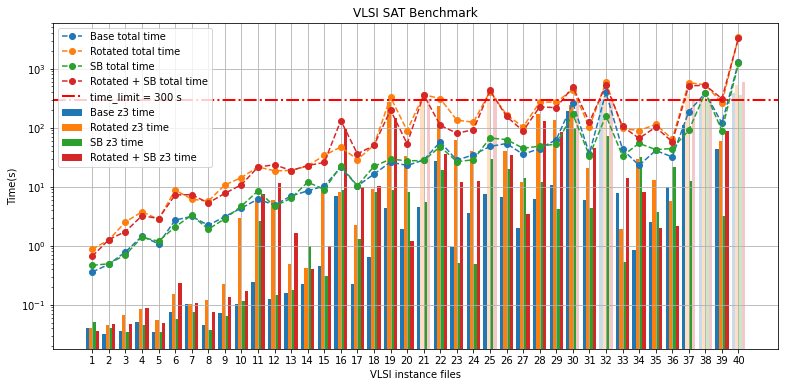

total Base time        -- mean: 84.05892421007157 std: 213.00970281590347 
total rotated time     -- mean: 228.47448337078094 std: 534.0534764266798 
total SB time          -- mean: 73.30091633796692 std: 198.6454423268334 
total rotated + SB time-- mean: 214.42832576036454 std: 528.3730910698112 
z3 Base time           -- mean: 36.433525 std: 91.87860983275364 
z3 rotated time        -- mean: 88.93515 std: 135.67435828474552 
z3 SB time             -- mean: 26.50365 std: 73.02180425275384 
z3 rotated + SB time   -- mean: 80.1276 std: 136.38829499223897


In [6]:
import numpy as np 
import matplotlib.pyplot as plt 
import time
from tqdm import tqdm
%matplotlib inline

def plot_SAT_benchmark(instances_to_solve = 5,timeout = 300, plot=False):
    '''
    Plotting the barplot with all the SAT solving mechanisms (base, rotated, 
    base + symmetry breaking, rotated + symmetry breaking)
    '''

    times_base = []
    times_base_rotate = []
    times_SB = []
    times_SB_rotate = []

    z3_times_base = []
    z3_times_base_rotate = []
    z3_times_SB = []
    z3_times_SB_rotate = []

    time_overs_base = []
    time_overs_base_rotate = []
    time_overs_SB = []
    time_overs_SB_rotate = []
    
    for i in tqdm(range(1, instances_to_solve + 1)):
        url = f"../instances/ins-{i}.txt"
        _, _, timer, time_over, z3_timer = VLSI_SAT_solver().solve(instance_path = url, timeout= timeout, break_symmetries = True ,rotate=False, verbose = plot, plot = plot)
        times_SB.append(timer)
        z3_times_SB.append(z3_timer)

        if(time_over):
            time_overs_SB.append(i-1)

        url = f"../instances/ins-{i}.txt"
        _, _, timer, time_over, z3_timer = VLSI_SAT_solver().solve(instance_path = url, timeout= timeout, break_symmetries = True ,rotate=True, verbose = plot, plot = plot)
        times_SB_rotate.append(timer)
        z3_times_SB_rotate.append(z3_timer)

        if(time_over):
            time_overs_SB_rotate.append(i-1)

        url = f"../instances/ins-{i}.txt"
        _, _, timer, time_over, z3_timer = VLSI_SAT_solver().solve(instance_path = url, timeout= timeout, break_symmetries = False ,rotate=False, verbose = plot, plot = plot)
        times_base.append(timer)
        z3_times_base.append(z3_timer)

        if(time_over):
            time_overs_base.append(i-1)

        url = f"../instances/ins-{i}.txt"
        _, _, timer, time_over, z3_timer = VLSI_SAT_solver().solve(instance_path = url, timeout= timeout, break_symmetries = False ,rotate=True, verbose = plot, plot = plot)
        times_base_rotate.append(timer)
        z3_times_base_rotate.append(z3_timer)

        if(time_over):
            time_overs_base_rotate.append(i-1)

    X = range(1, instances_to_solve + 1) 
    X_axis = np.arange(0,len(times_SB)*2,2)


    plt.rcParams["figure.figsize"] = (13,6)
    plt.xticks(X_axis, X)



    # base z3
    barbase = plt.bar(X_axis - 0.6, z3_times_base, 0.4, label = 'Base z3 time')
  
    # base total
    plt.plot(X_axis, times_base, linestyle='--', marker='o', label='Base total time')

    for i in time_overs_base:  
        barbase[i].set_alpha(0.25)
  
    # base + rotation z3
    barbaserotation = plt.bar(X_axis - 0.2, z3_times_base_rotate, 0.4, label = 'Rotated z3 time')
  
    # base + rotation total
    plt.plot(X_axis, times_base_rotate, linestyle='--', marker='o', label='Rotated total time')

    for i in time_overs_base_rotate:
        barbaserotation[i].set_alpha(0.25)

    # SB
    barSB = plt.bar(X_axis + 0.2, z3_times_SB, 0.4, label = 'SB z3 time')
  
    # SB total
    plt.plot(X_axis, times_SB, linestyle='--', marker='o', label='SB total time')

    for i in time_overs_SB:  
        barSB[i].set_alpha(0.25)
        
    # SB + rotation
    barSBrotation = plt.bar(X_axis + 0.6, z3_times_SB_rotate, 0.4, label = 'Rotated + SB z3 time')

    #SB + rotation total
    plt.plot(X_axis, times_SB_rotate, linestyle='--', marker='o', label='Rotated + SB total time')

    for i in time_overs_SB_rotate:  
        barSBrotation[i].set_alpha(0.25)

    plt.xlabel("VLSI instance files")
    plt.ylabel("Time(s)")
    plt.title("VLSI SAT Benchmark")
    plt.grid()
    plt.axhline(y=timeout, xmin=0, xmax=1, color='r', linestyle='-.', linewidth=2, label=f"time_limit = {timeout} s")
    #plt.yscale("log")
    plt.legend()
    plt.savefig('sat_benchmark.png', transparent=False,format="png")
    plt.show()

    out_text= ""

    out_text += f"total Base time        -- mean: {np.mean(times_base)} std: {np.std(times_base)} \n"
    out_text += f"total rotated time     -- mean: {np.mean(times_base_rotate)} std: {np.std(times_base_rotate)} \n"
    out_text += f"total SB time          -- mean: {np.mean(times_SB)} std: {np.std(times_SB)} \n"
    out_text += f"total rotated + SB time-- mean: {np.mean(times_SB_rotate)} std: {np.std(times_SB_rotate)} \n"

    out_text += f"z3 Base time           -- mean: {np.mean(z3_times_base)} std: {np.std(z3_times_base)} \n"
    out_text += f"z3 rotated time        -- mean: {np.mean(z3_times_base_rotate)} std: {np.std(z3_times_base_rotate)} \n"
    out_text += f"z3 SB time             -- mean: {np.mean(z3_times_SB)} std: {np.std(z3_times_SB)} \n"
    out_text += f"z3 rotated + SB time   -- mean: {np.mean(z3_times_SB_rotate)} std: {np.std(z3_times_SB_rotate)}"

 # write txt log
    with  open("sat_benchmark_log.txt","w") as file:
        content = out_text
        file.writelines(content)
        file.close()
        
    print(out_text)
#timeout is set in seconds
plot_SAT_benchmark(instances_to_solve=40, timeout=300, plot=False)

## Constraints

We should take into account that $\textbf{all}$ the whole rectangle and not just the left-bottom corner must fit into the width $W$ and height $H$ of the strip, therefore the following constraints must be satisfied (for each rectangle $r_i$):

$$enc_{x_{i},W-width_i} \wedge ... \wedge enc_{x_{i},W-1}$$
$$enc_{y_{i},H-height_i} \wedge ... \wedge enc_{y_{i},H-1}$$

Then we add the order encoding constraint described in the previous section (for each rectangle $r_i$):

$$\neg enc_{x_i,j} \vee enc_{x_i,j+1} \qquad j \in \{0,..,W-2\}$$
$$\neg enc_{y_i,k} \vee enc_{y_i,k+1} \qquad k \in \{0,..,H-2\}$$

Finally, we have the $\textbf{no-overlap}$ constraints:
Every rectangle has a relative position w.r.t. another, so (for each rectangle $r_i$,$r_j$ with $i < j$ and $i,j \in \{0,N-1\}$): 

$$lr_{i,j} \vee lr_{j,i} \vee ud_{i,j} \vee ud_{j,i}$$

we should now chain the meaning of the relative position variables with all the other variables and to do that we can think about that, as an example, if a rectangle is at the left of another, the left rectangle left-bottom corner has a distance from the bottom-left corner of the right rectangle that is at least equal to the width of the left rectangle (we can then extend this reasoning to the up-down positioning)

1. $$lr_{i,j} \Rightarrow x_i + width_i \leq x_j$$
2. $$lr_{j,i} \Rightarrow x_j + width_j \leq x_i$$
3. $$ud_{i,j} \Rightarrow y_i + height_i \leq y_j$$
4. $$ud_{j,i} \Rightarrow y_j + height_j \leq y_i$$





### Encoding of inequalities in SAT
if we have an inequality of the form 
$$x + c \leq y$$
where $c \in \{ 0..n_{max}\}$ and so that $|enc_{x}| = |enc_{y}|=n_{max}$, then 
* $x \leq z, \qquad z \in  \{ n_{max}-c, .., n_{max}\} $
* $y \geq t, \qquad t \in  \{0, ..,c\} \quad \text{which can be rewritten as } \quad \neg (y \leq k), \qquad k \in \{0, .., c-1\}$
* $(y \leq c + s) \rightarrow  (x \leq s), \qquad s \in \{0, .., n_{max} -c- 1\}$

The formulas above are rewritable as literals, each one corresponding to a simple inequality:

* $enc_{x,z} \qquad z \in  \{ n_{max}-c, .., n_{max}-1\} $
* $\neg enc_{y,t} \qquad t \in \{0, .., c-1\}$
* $enc_{y,c+s} \rightarrow enc_{x,s} \qquad s \in \{ 0,.., n_{max}-c-1\} \quad \text{which can be rewritten as} \quad \neg enc_{y,c+s} \vee enc_{x,s} \qquad s \in \{ 0,.., n_{max}-c-1\}$



$\qquad  $

## The inequalities are therefore transformed in the following formulas:


1.
*   $lr_{i,j} \rightarrow {enc}_{x_{i},z}  \qquad z \in \{W-{width}_i,..,W-1 \}$
*   $lr_{i,j} \rightarrow \neg {enc}_{x_{j},t} \qquad t \in \{ 0,.., {width}_i -1\}$
*   $lr_{i,j} \rightarrow (\neg {enc}_{x_{j},{width}_i+s} \vee {enc}_{x_{i},s}) \qquad s \in \{ 0,.., W-{width}_i-1\}$

2.
*   $lr_{j,i} \rightarrow {enc}_{x_{j},z}  \qquad z \in \{W-{width}_j,..,W-1 \}$
*   $lr_{j,i} \rightarrow \neg {enc}_{x_{i},t} \qquad t \in \{ 0,.., {width}_j -1\}$
*   $lr_{j,i} \rightarrow (\neg {enc}_{x_{i},{width}_j+s} \vee {enc}_{x_{j},s}) \qquad s \in \{ 0,.., W-{width}_j-1\}$

3.
* $ud_{i,j} \rightarrow {enc}_{y_{i},z} \qquad z \in \{ H-{height}_i,..,H-1 \}$
* $ud_{i,j} \rightarrow \neg{enc}_{y_{j},t} \qquad t \in \{ 0,.., {height}_i -1\}$
* $ud_{i,j} \rightarrow (\neg {enc}_{y_{j},height_{i}+s} \vee enc_{y_{i},s}) \qquad s \in \{ 0, ..,H-height_i-1\}$

4.
* $ud_{j,i} \rightarrow {enc}_{y_{j},z} \qquad z \in \{ H-{height}_j,..,H-1 \}$
* $ud_{j,i} \rightarrow \neg{enc}_{y_{i},t} \qquad t \in \{ 0,.., {height}_j -1\}$
* $ud_{j,i} \rightarrow (\neg {enc}_{y_{i},height_{j}+s} \vee enc_{y_{j},s}) \qquad s \in \{ 0,.., H-height_j-1\}$


The first formula of each term can be avoided because the righthand side of that implication is already made true by the first described constraint, therefore we obtain 

1.
*   $\neg lr_{i,j} \vee \neg {enc}_{x_{j},t} \qquad t \in \{ 0,.., {width}_i -1\}$
*   $\neg lr_{i,j} \vee \neg {enc}_{x_{j},{width}_i+s} \vee {enc}_{x_{i},s} \qquad s \in \{ 0,.., W-{width}_i-1\}$

2.
*   $\neg lr_{j,i} \vee \neg {enc}_{x_{i},t} \qquad t \in \{ 0,.., {width}_j -1\}$
*   $\neg lr_{j,i} \vee \neg {enc}_{x_{i},{width}_j+s} \vee {enc}_{x_{j},s} \qquad s \in \{ 0,.., W-{width}_j-1\}$

3.
* $\neg ud_{i,j} \vee \neg{enc}_{y_{j},t} \qquad t \in \{ 0,.., {height}_i -1\}$
* $\neg ud_{i,j} \vee \neg {enc}_{y_{j},height_{i}+s} \vee enc_{y_{i},s} \qquad s \in \{ 0,.., H-height_i-1\}$

4.
* $\neg ud_{j,i} \vee \neg{enc}_{y_{i},t} \qquad t \in \{ 0,.., {height}_j -1\}$
* $\neg ud_{j,i} \vee \neg {enc}_{y_{i},height_{j}+s} \vee enc_{y_{j},s} \qquad s \in \{ 0,.., H-height_j-1\}$


## Symmetry Breaking Constraints

In order to make the computation faster it is necessary to prune the search space reducing the number of clauses and literals involved (contrarily to CP, where adding constraints makes the detection of unfeasible solutions faster).

We've applied 3 kinds of

### 1. Large Rectangles (LR) Symmetry Breaking
If the sum of two rectangles widths is bigger than the width of the strip (i.e. ${width}_i$ + ${width}_j$>W) we can assume that they can't be placed one on the left or right side of the other and we can delete some of the constraints:
%TODO delete first and second term
$$lr_{i,j} \vee lr_{j,i} \vee ud_{i,j} \vee ud_{j,i}$$
%TODO delete formulas in point 1 and 2

%this 1.
*   $\neg lr_{i,j} \vee \neg {enc}_{x_{j},t} \qquad t \in \{ 0,.., {width}_i -1\}$
*   $\neg lr_{i,j} \vee \neg {enc}_{x_{j},{width}_i+s} \vee {enc}_{x_{i},s} \qquad s \in \{ 0,.., W-{width}_i-1\}$

%this
2.
*   $\neg lr_{j,i} \vee \neg {enc}_{x_{i},t} \qquad t \in \{ 0,.., {width}_j -1\}$
*   $\neg lr_{j,i} \vee \neg {enc}_{x_{i},{width}_j+s} \vee {enc}_{x_{j},s} \qquad s \in \{ 0,.., W-{width}_j-1\}$

3.
* $\neg ud_{i,j} \vee \neg{enc}_{y_{j},t} \qquad t \in \{ 0, {height}_i -1\}$
* $\neg ud_{i,j} \vee \neg {enc}_{y_{j},height_{i}+s} \vee enc_{y_{i},s} \qquad s \in \{ 0, H-height_i-1\}$

4.
* $\neg ud_{j,i} \vee \neg{enc}_{y_{i},t} \qquad t \in \{ 0,.., {height}_j -1\}$
* $\neg ud_{j,i} \vee \neg {enc}_{y_{i},height_{j}+s} \vee enc_{y_{j},s} \qquad s \in \{ 0,.., H-height_j-1\}$

We can also apply the same reasoning to the height, because if ${height}_i$ + ${height}_j$>H we can assume that those rectangles can't be placed one above or under the other and we can delete these constraints:
%TODO delete third and fourth term
$$lr_{i,j} \vee lr_{j,i} \vee ud_{i,j} \vee ud_{j,i}$$
%TODO delete formulas in point 3 and 4
1.
*   $\neg lr_{i,j} \vee \neg {enc}_{x_{j},t} \qquad t \in \{ 0,.., {width}_i -1\}$
*   $\neg lr_{i,j} \vee \neg {enc}_{x_{j},{width}_i+s} \vee {enc}_{x_{i},s} \qquad s \in \{ 0,.., W-{width}_i-1\}$

2.
*   $\neg lr_{j,i} \vee \neg {enc}_{x_{i},t} \qquad t \in \{ 0,.., {width}_j -1\}$
*   $\neg lr_{j,i} \vee \neg {enc}_{x_{i},{width}_j+s} \vee {enc}_{x_{j},s} \qquad s \in \{ 0,.., W-{width}_j-1\}$

% this 3.
* $\neg ud_{i,j} \vee \neg{enc}_{y_{j},t} \qquad t \in \{ 0, {height}_i -1\}$
* $\neg ud_{i,j} \vee \neg {enc}_{y_{j},height_{i}+s} \vee enc_{y_{i},s} \qquad s \in \{ 0, H-height_i-1\}$

% this 4.
* $\neg ud_{j,i} \vee \neg{enc}_{y_{i},t} \qquad t \in \{ 0,.., {height}_j -1\}$
* $\neg ud_{j,i} \vee \neg {enc}_{y_{i},height_{j}+s} \vee enc_{y_{j},s} \qquad s \in \{ 0,.., H-height_j-1\}$



%TODO delete first term
$$lr_{i,j} \vee lr_{j,i} \vee ud_{i,j} \vee ud_{j,i}$$
%TODO delete formulas in point 1 and 2

%this 1.
*   $\neg lr_{i,j} \vee \neg {enc}_{x_{j},t} \qquad t \in \{ 0,.., {width}_i -1\}$
*   $\neg lr_{i,j} \vee \neg {enc}_{x_{j},{width}_i+s} \vee {enc}_{x_{i},s} \qquad s \in \{ 0,.., W-{width}_i-1\}$

%this
2.
*   $\neg lr_{j,i} \vee \neg {enc}_{x_{i},t} \qquad t \in \{ 0,.., {width}_j -1\}$
*   $\neg lr_{j,i} \vee \neg {enc}_{x_{i},{width}_j+s} \vee {enc}_{x_{j},s} \qquad s \in \{ 0,.., W-{width}_j-1\}$

3.
* $\neg ud_{i,j} \vee \neg{enc}_{y_{j},t} \qquad t \in \{ 0,.., {height}_i -1\}$
* $\neg ud_{i,j} \vee \neg {enc}_{y_{j},height_{i}+s} \vee enc_{y_{i},s} \qquad s \in \{ 0,.., H-height_i-1\}$

4.
* $\neg ud_{j,i} \vee \neg{enc}_{y_{i},t} \qquad t \in \{ 0,.., {height}_j -1\}$
* $\neg ud_{j,i} \vee \neg {enc}_{y_{i},height_{j}+s} \vee enc_{y_{j},s} \qquad s \in \{ 0,.., H-height_j-1\}$

### 2. Same Sized Rectangles (SR) Symmetry Breaking
If two rectangles are such that $width_i = width_j$ and $height_i = height_j$ we can choose to have rectangle $i$ left-under $j$:


%TODO delete second term
$$lr_{i,j} \vee lr_{j,i} \vee ud_{i,j} \vee ud_{j,i}$$
%TODO delete formulas in point 2 
1.
*   $\neg lr_{i,j} \vee \neg {enc}_{x_{j},t} \qquad t \in \{ 0,.., {width}_i -1\}$
*   $\neg lr_{i,j} \vee \neg {enc}_{x_{j},{width}_i+s} \vee {enc}_{x_{i},s} \qquad s \in \{ 0,.., W-{width}_i-1\}$

% this 2.
*   $\neg lr_{j,i} \vee \neg {enc}_{x_{i},t} \qquad t \in \{ 0,.., {width}_j -1\}$
*   $\neg lr_{j,i} \vee \neg {enc}_{x_{i},{width}_j+s} \vee {enc}_{x_{j},s} \qquad s \in \{ 0,.., W-{width}_j-1\}$

3.
* $\neg ud_{i,j} \vee \neg{enc}_{y_{j},t} \qquad t \in \{ 0,.., {height}_i -1\}$
* $\neg ud_{i,j} \vee \neg {enc}_{y_{j},height_{i}+s} \vee enc_{y_{i},s} \qquad s \in \{ 0,.., H-height_i-1\}$

4.
* $\neg ud_{j,i} \vee \neg{enc}_{y_{i},t} \qquad t \in \{ 0,.., {height}_j -1\}$
* $\neg ud_{j,i} \vee \neg {enc}_{y_{i},height_{j}+s} \vee enc_{y_{j},s} \qquad s \in \{ 0,.., H-height_j-1\}$

% this formula is added:
Adding just a new formula:
$ud_{i,j} \rightarrow {lr}_{j,i}$ rewritable as $\neg ud_{i,j} \vee {lr}_{j,i}$


### 3. Largest Sized Rectangle (LS) Symmetry Breaking 

We can also assume to have the biggest rectangle (in terms of area) $largest$ placed in the left bottom half of the rectangle. This makes it possible to restrict the domain:
$$enc_{x_{largest},i}, \qquad i \in \{ \lfloor \frac{W-width_{largest}}{2} \rfloor, W-1 \}$$
$$enc_{y_{largest},j}, \qquad j \in \{ \lfloor \frac{H-height_{largest}}{2} \rfloor, H-1 \}$$

And delete some overlapping constraints:

%TODO delete first term, third term
$$lr_{i,largest} \vee lr_{largest,i} \vee ud_{i,largest} \vee ud_{largest,i}$$
%TODO delete formulas in point 1 and 3

% this 1.
*   $\neg lr_{i,largest} \vee \neg {enc}_{x_{largest},t} \qquad t \in \{ 0,.., {width}_i -1\}$
*   $\neg lr_{i,largest} \vee \neg {enc}_{x_{largest},{width}_i+s} \vee {enc}_{x_{i},s} \qquad s \in \{ 0,.., W-{width}_i-1\}$

2.
*   $\neg lr_{largest,i} \vee \neg {enc}_{x_{i},t} \qquad t \in \{ 0,.., {width}_largest -1\}$
*   $\neg lr_{largest,i} \vee \neg {enc}_{x_{i},{width}_{largest}+s} \vee {enc}_{x_{largest},s} \qquad s \in \{ 0,.., W-{width}_{largest}-1\}$

%this 3.
* $\neg ud_{i,largest} \vee \neg{enc}_{y_{largest},t} \qquad t \in \{ 0,.., {height}_i -1\}$
* $\neg ud_{i,largest} \vee \neg {enc}_{y_{largest},height_{i}+s} \vee enc_{y_{i},s} \qquad s \in \{ 0,.., H-height_i-1\}$

4.
* $\neg ud_{largest,i} \vee \neg{enc}_{y_{i},t} \qquad t \in \{ 0,.., {height}_{largest} -1\}$
* $\neg ud_{largest,i} \vee \neg {enc}_{y_{i},height_{largest}+s} \vee enc_{y_{largest},s} \qquad s \in \{ 0,.., H-height_{largest}-1\}$






## A variant: rotations

We've introduced a new variable $r$ for each instance, it is True if the rectangle is rotated, False if it is not.

%TODO properly link formulas

Therefore, we've rewritten the formulas (0-4) in the following way, considering that if a rectangle is rotated, its height and width are inverted:

1.
*   $\neg R_i \rightarrow (\neg lr_{i,j} \vee \neg {enc}_{x_{j},t}) \qquad t \in \{ 0,.., {width}_i -1\}$
*   $\neg R_i \rightarrow (\neg lr_{i,j} \vee \neg {enc}_{x_{j},{width}_i+s} \vee {enc}_{x_{i},s}) \qquad s \in \{ 0,.., W-{width}_i-1\}$
*   $ R_i \rightarrow (\neg lr_{i,j} \vee \neg {enc}_{x_{j},t}) \qquad t \in \{ 0,.., {height}_i -1\}$
*   $ R_i \rightarrow (\neg lr_{i,j} \vee \neg {enc}_{x_{j},{height}_i+s} \vee {enc}_{x_{i},s}) \qquad s \in \{ 0,.., W-{height}_i-1\}$

2.
*   $\neg R_j \rightarrow (\neg lr_{j,i} \vee \neg {enc}_{x_{i},t}) \qquad t \in \{ 0,.., {width}_j -1\}$
*   $\neg R_j \rightarrow (\neg lr_{j,i} \vee \neg {enc}_{x_{i},{width}_j+s} \vee {enc}_{x_{j},s}) \qquad s \in \{ 0,.., W-{width}_j-1\}$
*   $ R_j \rightarrow (\neg lr_{j,i} \vee \neg {enc}_{x_{i},t}) \qquad t \in \{ 0,.., {height}_j -1\}$
*   $ R_j \rightarrow (\neg lr_{j,i} \vee \neg {enc}_{x_{i},{height}_j+s} \vee {enc}_{x_{j},s}) \qquad s \in \{ 0,.., W-{height}_j-1\}$

3.
* $\neg R_i \rightarrow (\neg ud_{i,j} \vee \neg{enc}_{y_{j},t}) \qquad t \in \{ 0,.., {height}_i -1\}$
* $\neg R_i \rightarrow (\neg ud_{i,j} \vee \neg {enc}_{y_{j},height_{i}+s} \vee enc_{y_{i},s}) \qquad s \in \{ 0,.., H-height_i-1\}$
* $R_i \rightarrow (\neg ud_{i,j} \vee \neg{enc}_{y_{j},t}) \qquad t \in \{ 0,.., {width}_i -1\}$
* $R_i \rightarrow (\neg ud_{i,j} \vee \neg {enc}_{y_{j},width_{i}+s} \vee enc_{y_{i},s}) \qquad s \in \{ 0,.., H-width_i-1\}$

4.
* $\neg R_j \rightarrow (\neg ud_{j,i} \vee \neg{enc}_{y_{i},t}) \qquad t \in \{ 0,.., {height}_j -1\}$
* $\neg R_j \rightarrow (\neg ud_{j,i} \vee \neg {enc}_{y_{i},height_{j}+s} \vee enc_{y_{j},s}) \qquad s \in \{ 0,.., H-height_j-1\}$
* $R_j \rightarrow (\neg ud_{j,i} \vee \neg{enc}_{y_{i},t}) \qquad t \in \{ 0,.., {width}_j -1\}$
* $R_j \rightarrow (\neg ud_{j,i} \vee \neg {enc}_{y_{i},width_{j}+s} \vee enc_{y_{j},s}) \qquad s \in \{ 0,.., H-width_j-1\}$



## Squares Symmetry Breaking

In the version with rotations, We've added a nove constraint that makes it possible to avoid rotations when the rectangle is actually just a square (in this way we avoid the symmetry obtained simply rotating it). In order to apply this symmetry breaking strategy it is necessary to check if $width_i = height_i$: in that case the additional variable r_i is removed in the constraints.